# Blog:  https://maelfabien.github.io/machinelearning/NLP_5/#implementation


In [15]:
import pandas as pd
import numpy as np
from random import seed
from random import sample
import re

seed(42)
np.random.seed(42)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import gensim.downloader as api
from gensim.models.keyedvectors import Word2VecKeyedVectors

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import spatial

from nltk.corpus import stopwords

In [6]:
model2 = api.load('word2vec-google-news-300')

In [7]:
df = pd.read_json('./project-1-at-2023-03-27-00-39-6ca34300 (1).json')

In [8]:
texts = []
labels = []
for label_list in df['label-General'].values.tolist():
    for label in label_list:
        texts.append(label['text'])
        labels.append(label['labels'][0])

In [9]:
len(labels) == len(texts)

True

In [10]:
df_esg = pd.DataFrame({'text': texts, 'label': labels})

In [11]:
df_esg

,text,label
0,"We, the shareholders, must protect our assets ...",Environmental Positive
1,we therefore support companies to substantiall...,Environmental Positive
2,"We, the shareholders, must protect our assets ...",Governence Positive
3,Shareholders request the Company to substantia...,Environmental Positive
4,Shareholders request the Company to substanti...,Governence Positive
...,...,...
421,With this review Shell have set the benchmark ...,Environmental Positive
422,With this review Shell have set the benchmark ...,Governence Positive
423,Shell said it will continue to engage with the...,Governence Positive
424,Shell last month urged President Donald Trump’...,Environmental Positive


In [12]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_sentence(sentence):
    """
    Cleans a sentence by removing punctuation, making all characters lowercase,
    and removing stop words.
    
    Args:
    - sentence (str): The sentence to clean.
    
    Returns:
    - cleaned_sentence (str): The cleaned sentence.
    """
    # Remove punctuation
    cleaned_sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    
    # Make lowercase
    cleaned_sentence = cleaned_sentence.lower()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    cleaned_sentence = " ".join(word for word in cleaned_sentence.split() if word not in stop_words)
    
    return cleaned_sentence


[nltk_data] Downloading package stopwords to C:\Users\Risto
[nltk_data]     Trajanov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df_esg['text'] = df_esg['text'].apply(lambda x: clean_sentence(x))

In [51]:
len(df_esg['label'].value_counts()[df_esg['label'].value_counts()>30])

5

In [47]:
labels_valid = df_esg['label'].value_counts()[df_esg['label'].value_counts()>30].index.tolist()

In [54]:
labels_valid

['Environmental Positive',
 'Governence Positive',
 'Governence Negative',
 'Environmental Negative',
 'Governence Neutral']

In [55]:
# labels_set = set(df_esg['label'])
labels_set = set(labels_valid)
label_map = {label:i for label, i in zip(list(labels_set), range(len(labels_set)))}

In [56]:
label_map

{'Environmental Positive': 0,
 'Governence Negative': 1,
 'Environmental Negative': 2,
 'Governence Positive': 3,
 'Governence Neutral': 4}

In [58]:
df_esg_valid = df_esg[df_esg['label'].isin(labels_valid)]

In [59]:
df_esg_valid['label_id'] = [label_map[label] for label in df_esg_valid['label']]

c:\Users\Risto Trajanov\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
# Generate samples that contains K samples of each class

def gen_sample(sample_size, num_classes, df):

    df_1 = df[(df["Label"]<num_classes + 1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    train = df_1[df_1["Label"] == np.unique(df_1['Label'])[0]].sample(sample_size)

    train_index = train.index.tolist()

    for i in range(1,num_classes):
        train_2 = df_1[df_1["Label"] == np.unique(df_1['Label'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())

    test = df_1[~df_1.index.isin(train_index)]

    return train, test

In [61]:
df = pd.DataFrame({'Text': df_esg_valid['text'], 
                   'Label': df_esg_valid['label_id']})

In [62]:
num_classes = 5
sample_size = 30

In [63]:
train, test = gen_sample(sample_size, num_classes, df)

X_train = train['Text']
y_train = train['Label'].values
X_test = test['Text']
y_test = test['Label'].values

In [66]:
# Text processing (split, find token id, get embedidng)
def transform_sentence(text, model):
    """
    Mean embedding vector
    """
    def preprocess_text(raw_text, model=model):

        """ 
        Excluding unknown words and get corresponding token
        """

        raw_text = raw_text.split()

        return list(filter(lambda x: x in model.index_to_key, raw_text))

    tokens = preprocess_text(text)

    if not tokens:
        return np.zeros(model.vector_size)

    text_vector = np.mean(model[tokens], axis=0)

    return np.array(text_vector)

In [67]:
X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

In [68]:
X_train_mean

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
300,0.015422,0.105496,0.109348,0.005195,-0.158474,-0.043972,0.008358,-0.054552,0.050035,0.050469,...,-0.186822,0.004313,0.008952,0.011827,-0.057258,0.008735,0.089286,0.080285,0.129110,0.062500
262,-0.137451,0.061462,0.118164,0.113403,-0.114380,-0.167725,0.032898,-0.162872,0.218506,0.278076,...,-0.263428,-0.050293,0.096313,-0.059265,-0.130630,0.067719,-0.000336,0.110565,0.029724,0.066589
269,0.045715,-0.005253,0.139805,-0.068542,-0.032261,0.028774,0.094099,-0.275670,0.163452,0.059344,...,-0.166364,-0.040161,-0.113761,0.155901,0.049482,-0.057717,-0.075997,-0.056798,0.152919,0.056436
79,-0.034442,-0.031299,0.023230,0.031836,-0.114697,-0.071558,0.027069,-0.104883,0.129980,0.024365,...,-0.103177,0.082863,0.017908,-0.045935,-0.036285,0.048376,0.041296,0.065479,0.165227,0.041309
316,0.175293,0.045135,-0.056519,0.084717,-0.047485,-0.171021,0.135742,-0.004089,0.125244,0.250610,...,-0.252914,0.075562,0.201416,-0.027359,-0.049438,0.145996,0.222412,0.064941,0.157074,-0.067139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,-0.098328,0.045135,0.046527,0.090129,0.007111,-0.011222,0.011662,-0.080322,0.216069,0.006897,...,-0.051439,0.028103,-0.033821,0.042023,-0.000397,0.060448,0.051449,-0.109639,-0.047872,0.007622
313,-0.051838,0.038457,0.051732,0.021746,-0.105451,0.049683,0.038154,-0.072239,0.178170,-0.007417,...,-0.087742,0.151725,-0.083143,-0.066861,-0.017997,0.134478,0.051688,-0.042332,0.034363,-0.052098
180,-0.080024,0.085042,0.090413,0.053806,0.083944,-0.059752,0.005602,-0.058160,0.104947,0.030457,...,0.014466,0.053467,0.066254,-0.023261,0.023153,0.137099,0.083252,-0.106581,0.035753,-0.009033
309,-0.018338,0.101712,0.024170,0.148532,-0.107422,-0.138312,0.026233,-0.023722,0.119602,0.036804,...,-0.128866,0.023234,-0.002658,0.040145,-0.005100,-0.003499,-0.011000,0.047085,0.040826,0.008185


In [80]:
# Use cosine similarity to find closest class
def classify_txt(txt, mean_embedding):

    best_dist = 1
    best_label = -1

    for cl in range(num_classes):

        dist = spatial.distance.cosine(transform_sentence(txt, model2), mean_embedding[cl])

        if dist < best_dist :
            best_dist = dist
            best_label = cl

    return best_label

In [91]:
mean_embedding = {}
for cl in range(num_classes):
    mean_embedding[cl] = np.mean((X_train_mean[y_train == cl]), axis=0)

In [83]:
# Process text and predict on the test set
def return_score(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes, df)

    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    # mean_embedding = {}
    # for cl in range(num_classes):
    #     mean_embedding[cl] = np.mean((X_train_mean[y_train == cl]), axis=0)

    y_pred = [classify_txt(t, mean_embedding) for t in test['Text'].values]

    return accuracy_score(y_pred, y_test)

In [93]:
return_score(30, 5)

0.47058823529411764

In [96]:
from sklearn.neighbors import KNeighborsClassifier

def return_score(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes, df)

    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    clf = KNeighborsClassifier(n_neighbors=sample_size, p=2)
    clf.fit(X_train_mean, y_train)

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

In [97]:
return_score(30, 5)

0.5168067226890757

In [87]:
all_accuracy = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}

for num_samples in range(1, 30):
    # for num_cl in range(1, 5+1):
    all_accuracy[num_cl].append(return_score(num_samples, 5))

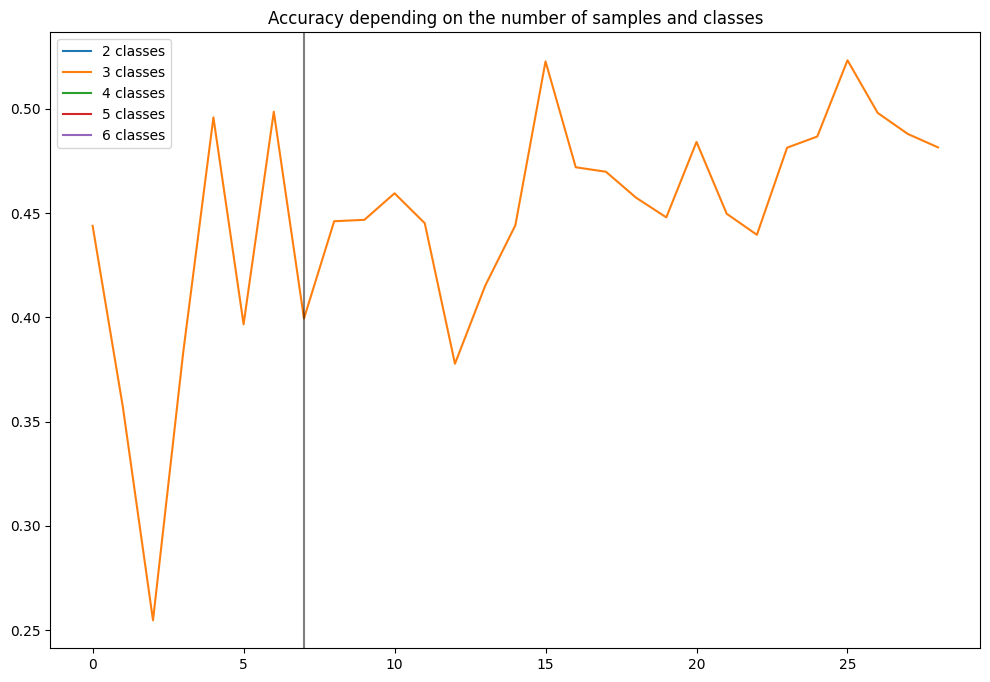

In [89]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy[0], label="2 classes")
plt.plot(all_accuracy[1], label="3 classes")
plt.plot(all_accuracy[2], label="4 classes")
plt.plot(all_accuracy[3], label="5 classes")
plt.plot(all_accuracy[4], label="6 classes")
plt.axvline(7, c='black', alpha=0.5)
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

In [90]:
all_accuracy

{0: [],
 1: [0.44386422976501305,
  0.35714285714285715,
  0.2546916890080429,
  0.38315217391304346,
  0.49586776859504134,
  0.39664804469273746,
  0.4985835694050991,
  0.3994252873563218,
  0.446064139941691,
  0.4467455621301775,
  0.4594594594594595,
  0.4451219512195122,
  0.37770897832817335,
  0.41509433962264153,
  0.4440894568690096,
  0.5227272727272727,
  0.47194719471947194,
  0.4697986577181208,
  0.45733788395904434,
  0.4479166666666667,
  0.4840989399293286,
  0.44964028776978415,
  0.43956043956043955,
  0.48134328358208955,
  0.4866920152091255,
  0.5232558139534884,
  0.4980237154150198,
  0.4879032258064516,
  0.48148148148148145],
 2: [],
 3: [],
 4: [],
 5: []}